In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv


# **Time Series forecasting with SARIMA on Global temperatures.csv**

SARIMA modelling is very similar to ARIMA modelling for non seasonal data, with added AR and MA terms that are seasonal in nature. ARIMA does not include seasonal data , and since we observe seasonality in the dataset, SARIMA models are better suited for prediction.In the ARIMA model (autoregressive integrated moving average), there are 3 terms, p,d,q that stand for autoregression order, difference and moving average order. Seasonal ARIMA has 4 seasonal elements, P,D,Q and m each of which denote seasonal AR, seasonal difference and seasonal moving average order. M stands for the lag value. The SARIMA model finally looks like :SARIMA (p,d,q)(P,D,Q)m. We aim to stationarize the series using differencing and the SARIMA model will be built upon parameters obtained from the ACF/PACF plots. 

[Helpful tutorial for TimeSeries Forecasting With sarima](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b)

## **IMPORTING DATA**

In [2]:
df = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv', header=0, index_col=0, parse_dates=True)
df.dropna(inplace=True)
df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [3]:
Temp = df.copy()
Temp.drop(['LandAverageTemperatureUncertainty','LandMaxTemperature','LandMaxTemperatureUncertainty','LandMinTemperature','LandMinTemperatureUncertainty','LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty'],
  axis='columns', inplace=True)
Temp.index.name = "Date"
Temp.columns= ['Temp']
Temp.head()

,Temp
Date,
1850-01-01,0.749
1850-02-01,3.071
1850-03-01,4.954
1850-04-01,7.217
1850-05-01,10.004


## **DATA VIZUALISATION**

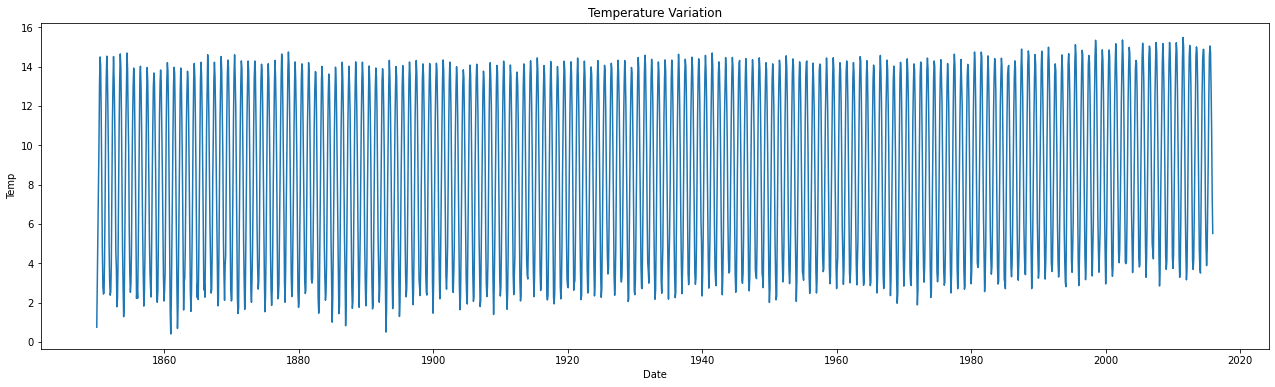

In [4]:
plt.figure(figsize=(22,6))
sns.lineplot(x=Temp.index, y=Temp['Temp'])
plt.title('Temperature Variation')
plt.show()

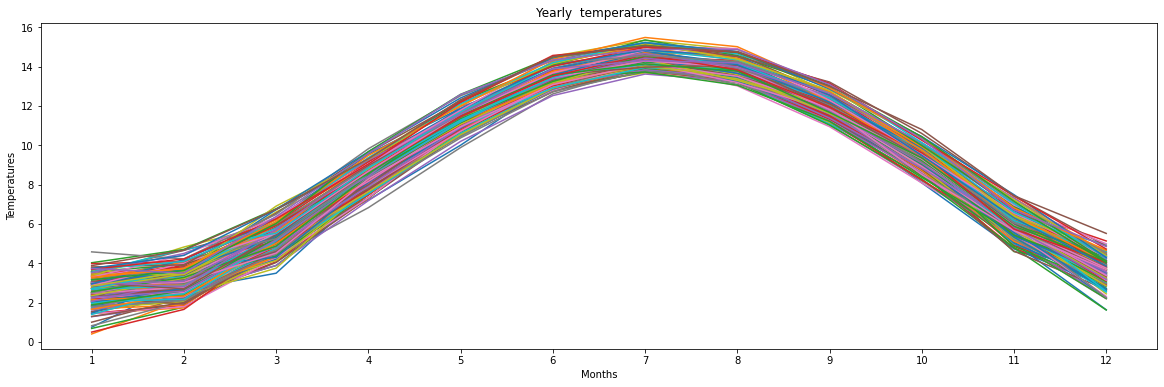

In [5]:
#creating a pivot table to plot the monthly temperatures through the years
Temp["month"] = Temp.index.month
Temp['year'] = Temp.index.year
pivot = pd.pivot_table(Temp, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Yearly  temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

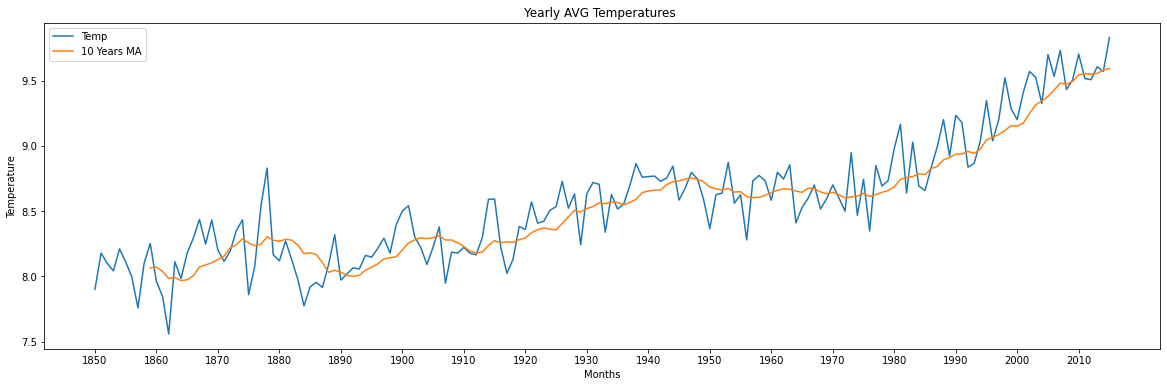

In [6]:
#To Observe Trends in the data
year_avg = pd.pivot_table(Temp, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Temperatures ')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1850,2015,10)])
plt.show()

**Clearly there is seasonality and trend in the data. Before creating the prediction model, its necessary to split the data into 3 parts - Training set, validation set and the test set.**

In [7]:
train = Temp[:-60].copy()
val = Temp[-60:-12].copy()
test = Temp[-12:].copy()

## MODELLING DATA

In [8]:
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2011-02-01     3.282
2011-03-01     3.743
2011-04-01     6.101
2011-05-01     9.483
2011-06-01    11.986
Name: Temp, dtype: float64

In [9]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} celsius degrees')

The RMSE of the baseline that we will try to diminish is 2.2422 celsius degrees


In [10]:
#Function to Check Stationarity using ADF test
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe series seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe series isn't stationary")

### Making the data Stationary

Results of Dickey-Fuller Test:
Test Statistic                   -1.7517
p-value                           0.4047
Lags Used                        26.0000
Number of Observations Used    1905.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The series isn't stationary


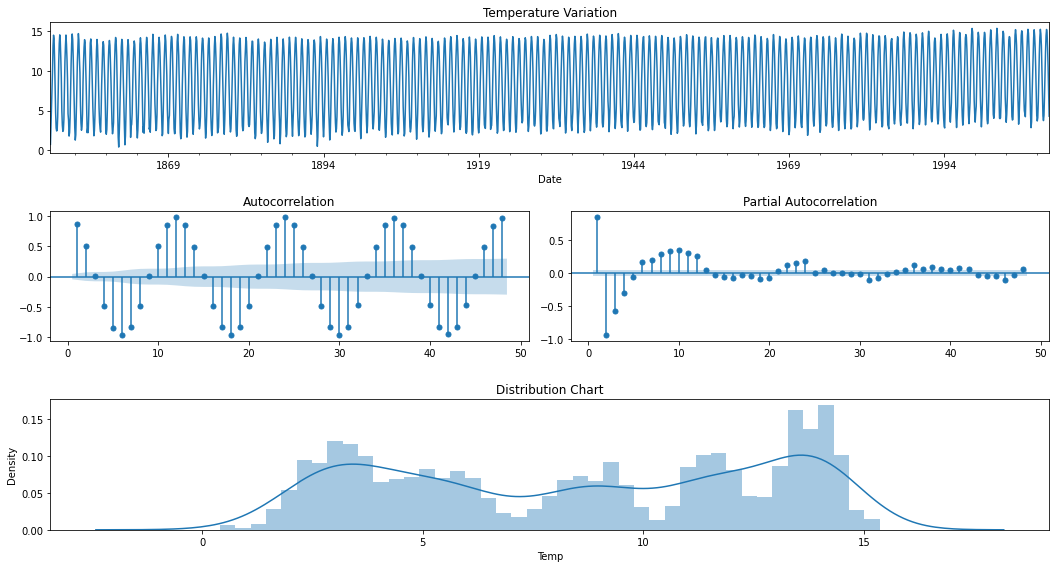

In [11]:
#Checking the stationarity of training data 
check_stationarity(train['Temp'])


The Output shows that the series isnt stationary. We'll stationarize it using differencing function.

Results of Dickey-Fuller Test:
Test Statistic                  -12.6681
p-value                           0.0000
Lags Used                        24.0000
Number of Observations Used    1895.0000
Critical Value (1%)              -3.4338
Critical Value (5%)              -2.8631
Critical Value (10%)             -2.5676
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


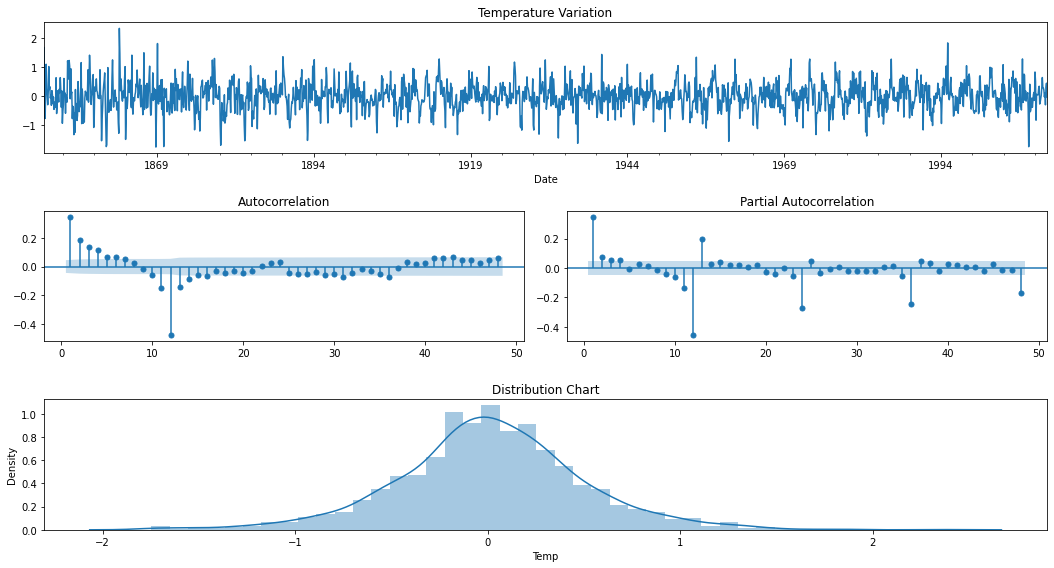

In [12]:
check_stationarity(train['Temp'].diff(12).dropna())

In [13]:
#Forecasting on Validation Set
def walk_forward(training_set, validation_set, params):
    '''
    Params: tuple where we put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [14]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((3,0,0),(0,1,1,12),'c'))

In [15]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(3,0,0),(0,1,1,12),'c' model was 0.2869 celsius degrees
It's a decrease of -87.21% in the RMSE


The lower the RMSE value the better. RMSE stands for Root Mean Square Error.

In [16]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']

def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [17]:
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Temp,Pred,Error
Date,,,
2011-01-01,3.282,3.563443,-0.281443
2011-02-01,3.743,4.057958,-0.314958
2011-03-01,6.101,6.067398,0.033602
2011-04-01,9.483,9.152425,0.330575
2011-05-01,11.986,12.055794,-0.069794


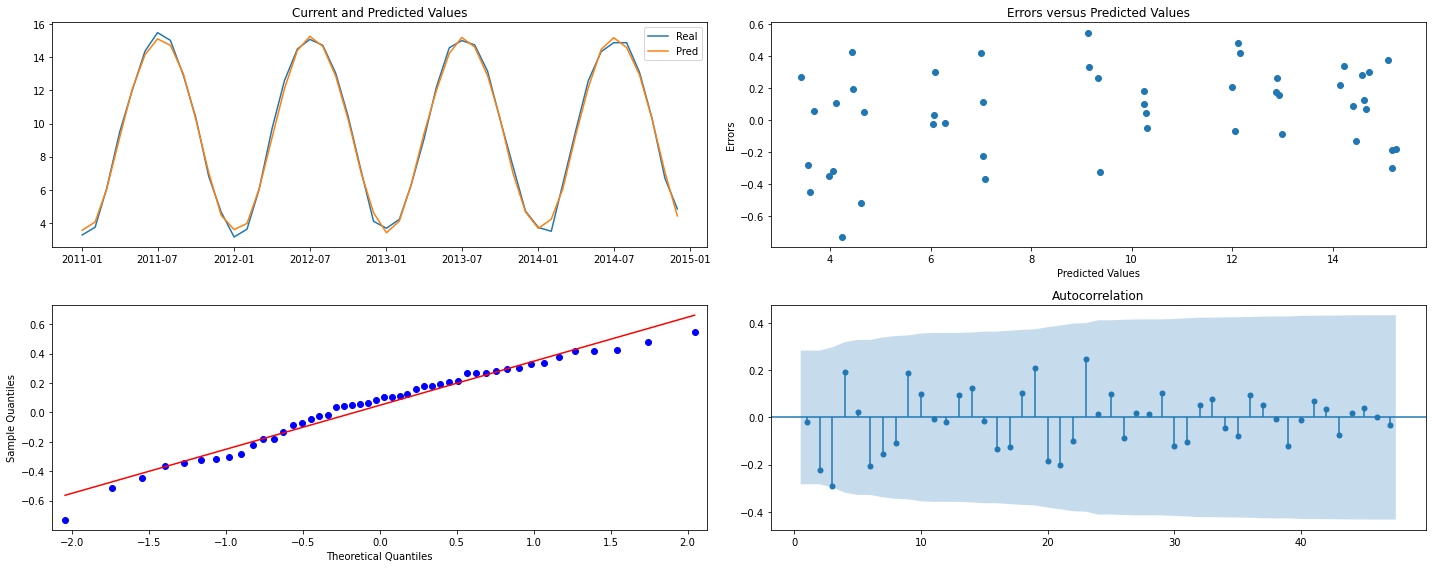

In [18]:
plot_error(val)

In [19]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1850-01-01     0.749
1850-02-01     3.071
1850-03-01     4.954
1850-04-01     7.217
1850-05-01    10.004
Name: Temp, dtype: float64

In [20]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

In [21]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+13))

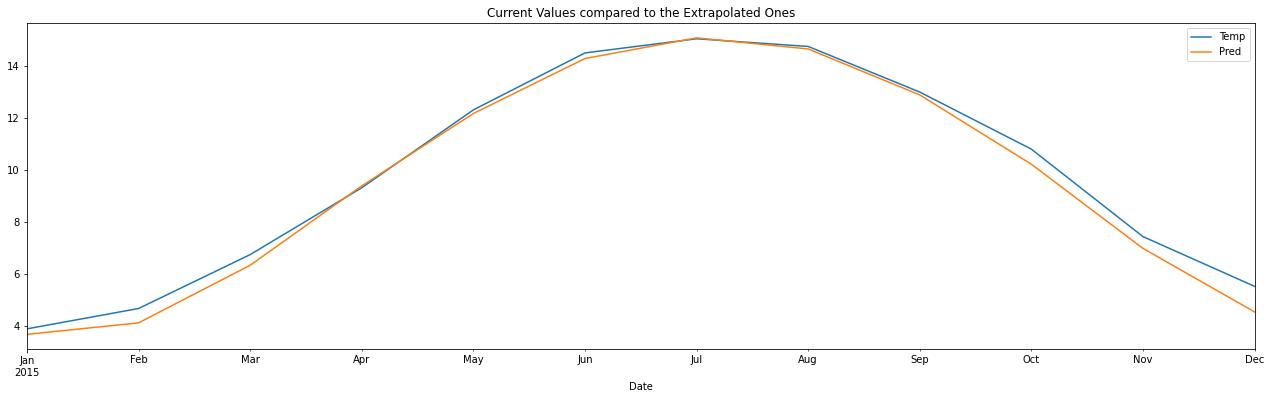

In [22]:
test[['Temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()